## PART 1 - API for Data Retrieval 

#### Data retrieved from kaggle - New York Times Articles 1920-2020

link to kaggle data: https://www.kaggle.com/datasets/tumanovalexander/nyt-articles-data

In [3]:
import kagglehub

# Download latest version from kaggle
path = kagglehub.dataset_download("tumanovalexander/nyt-articles-data")

print("Path to dataset files:", path)

/opt/anaconda3/envs/brand_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/shelbyjoji/.cache/kagglehub/datasets/tumanovalexander/nyt-articles-data/versions/3


In [4]:
import os

print("Files in dataset:")
print(os.listdir(path))

Files in dataset:
['nyt_data.parquet']


#### Load data

In [6]:
import pandas as pd

df = pd.read_parquet("/Users/shelbyjoji/.cache/kagglehub/datasets/tumanovalexander/nyt-articles-data/versions/3/nyt_data.parquet")
print(df.shape)
df.head()

(17370913, 3)


,year,title,excerpt
0,1920,At last the Federal Reserve Board has issued r...,
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...
2,1920,Sanction for Chinese Contracts.,
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...


#### Clean and prepare text 

##### **Remove rows where both 'title' and 'excerpt' are empty**

In [9]:
# Remove rows where both 'title' and 'excerpt' are empty (NaN or empty string)
df_cleaned = df[~((df['title'].isna() | (df['title'] == '')) & 
                                (df['excerpt'].isna() | (df['excerpt'] == '')))]

# Check the shape after removing the rows
print(f"Shape after cleaning: {df_cleaned.shape}")

Shape after cleaning: (17370879, 3)


##### **Find duplicates rows**

In [11]:
# creating a copy of dataframe
df_clean_new = df_cleaned.copy()


# Find rows with duplicate titles
duplicate_titles = df_clean_new[df_clean_new.duplicated('title', keep=False)]

print(f"Number of duplicate titles: {duplicate_titles.shape[0]}")

# Count occurrences of each title and filter for those with duplicates
title_counts = duplicate_titles.groupby('title').size().reset_index(name='count')

# Keep only titles with more than one occurrence
duplicate_title_counts = title_counts[title_counts['count'] > 1]
print(f"Titles with more than one occurrence: {duplicate_title_counts.shape[0]}")

# Optionally, save this to a new dataframe
duplicate_title_counts.head()

Number of duplicate titles: 12141978
Titles with more than one occurrence: 5489263


,title,count
0,,227
1,!,2
2,! Print the Recipes,2
3,! 'Son to Julian D. Fairchilds I,2
4,"! , I Christine Scarpmo Is Wed",2


##### **Remove duplicates**

In [13]:
# Remove duplicate rows, keeping the first occurrence for each title
df_no_duplicates = df_clean_new.drop_duplicates('title', keep='first')

# Check the shape after removing duplicates
print(f"Shape after removing duplicates: {df_no_duplicates.shape}")
df_no_duplicates.head()

Shape after removing duplicates: (10718164, 3)


,year,title,excerpt
0,1920,At last the Federal Reserve Board has issued r...,
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...
2,1920,Sanction for Chinese Contracts.,
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...


##### **Creating a new combined text field**

In [15]:
df_final = df_no_duplicates.copy()

# Combine title and excerpt into a single text field
df_final['full_text'] = (df_no_duplicates['title'].fillna('') + ' ' + df_no_duplicates['excerpt'].fillna('')).str.lower()

# shape of final dataframe
print(f"Shape of final dataframe: {df_final.shape}")
df_final.head()

Shape of final dataframe: (10718164, 4)


,year,title,excerpt,full_text
0,1920,At last the Federal Reserve Board has issued r...,,at last the federal reserve board has issued r...
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...,will test door service. service board to furth...
2,1920,Sanction for Chinese Contracts.,,sanction for chinese contracts.
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...,"leads frazier by 4,496. langer's margin falls ..."
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...,"chicago, april 30.--with 300 suspicious charac..."


## PART 2 - MongoDB

- NoSQL Database
- MongoDB is used to store and explore raw news article content.


#### Connect to MongoDB

In [19]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Create database
db = client["Brand_Analysis"]    

# Create collection
collection = db["Articles"]

#### Insert data into MongoDB

In [21]:
# Convert DataFrame to list of dictionaries
data = df_final.to_dict(orient='records')

# Insert data into MongoDB
collection.insert_many(data)

print("Data inserted successfully!")
print(f"Inserted {len(data)} records into MongoDB!")

Data inserted successfully!
Inserted 10718164 records into MongoDB!


#### Finding brand mentions in News articles

In [23]:
# List of brands
brands = ["nike", "adidas", "lululemon", "under armour", "new balance",
          "puma", "reebok", "asics", "hoka"]

# Create a brand frequency count
brand_counts = {}

for brand in brands:
    # Create regex query for each brand
    brand_regex = f"{brand}"
    query = {
        "full_text": {
            "$regex": brand_regex,
            "$options": "i"  # case insensitive
        }
    }
    
    # Count the documents mentioning this brand
    brand_count = collection.count_documents(query)
    brand_counts[brand] = brand_count
    print(f"Found {brand_count} articles mentioning '{brand}'")


# Sum all mentions
total_mentions = sum(brand_counts.values())
print(f"\nTotal brand mentions across all brands: {total_mentions}")

Found 2302 articles mentioning 'nike'
Found 335 articles mentioning 'adidas'
Found 33 articles mentioning 'lululemon'
Found 50 articles mentioning 'under armour'
Found 178 articles mentioning 'new balance'
Found 297 articles mentioning 'puma'
Found 479 articles mentioning 'reebok'
Found 1887 articles mentioning 'asics'
Found 207 articles mentioning 'hoka'

Total brand mentions across all brands: 5768


In [24]:
import pandas as pd

# Convert the brand_counts dictionary to a list of tuples (brand, count)
brand_data = [(brand, count) for brand, count in brand_counts.items()]

# Create a DataFrame from the list of tuples
brand_df = pd.DataFrame(brand_data, columns=["Brand", "Count"])

# Sort the DataFrame by the "Article Count" in descending order
brand_df = brand_df.sort_values(by="Count", ascending=False)

# Display the sorted DataFrame
print(brand_df.to_string(index=False))

       Brand  Count
        nike   2302
       asics   1887
      reebok    479
      adidas    335
        puma    297
        hoka    207
 new balance    178
under armour     50
   lululemon     33


#### create new field ('brands_mentioned') in MongoDB Database

In [26]:
from tqdm import tqdm

# Step to create 'brands_mentioned' field in Mongodb
for doc in tqdm(collection.find(), desc="Updating documents with brands mentioned"):
    mentioned_brands = []

    # Check if any brand is mentioned in the document's full_text
    for brand in brands:
        if brand.lower() in doc.get('full_text', '').lower():
            mentioned_brands.append(brand)

    # Update the document with the 'brands_mentioned' field
    if mentioned_brands:
        collection.update_one(
            {"_id": doc["_id"]},
            {"$set": {"brands_mentioned": mentioned_brands}}
        )

print("Successfully updated documents with 'brands_mentioned' field!")

Updating documents with brands mentioned: 10718164it [13:26, 13283.96it/s]

Successfully updated documents with 'brands_mentioned' field!


In [27]:
print(collection.count_documents({"brands_mentioned": {"$exists": True}}))

5581


In [28]:
# Printing first 5 documents where 'brands_mentioned' is not empty
for doc in collection.find({"brands_mentioned": {"$exists": True, "$ne": []}}).limit(10):
    print({
        "_id": doc["_id"],
        "title": doc.get("title", "")[:10],   # First 60 chars of title
        "brands_mentioned": doc["brands_mentioned"]
    })

{'_id': ObjectId('68093f828f3d2a47eb421abe'), 'title': 'BOSTON, Ja', 'brands_mentioned': ['nike']}
{'_id': ObjectId('68093f828f3d2a47eb422e29'), 'title': 'REPORT 100', 'brands_mentioned': ['nike']}
{'_id': ObjectId('68093f838f3d2a47eb44010e'), 'title': 'ROSENBERG,', 'brands_mentioned': ['nike']}
{'_id': ObjectId('68093f838f3d2a47eb4406f5'), 'title': 'Louis Chok', 'brands_mentioned': ['hoka']}
{'_id': ObjectId('68093f838f3d2a47eb440fad'), 'title': 'GROSS STRE', 'brands_mentioned': ['nike']}
{'_id': ObjectId('68093f838f3d2a47eb445184'), 'title': 'MOSCOW, Fe', 'brands_mentioned': ['nike']}
{'_id': ObjectId('68093f838f3d2a47eb445815'), 'title': 'MORE than ', 'brands_mentioned': ['hoka']}
{'_id': ObjectId('68093f838f3d2a47eb445eed'), 'title': 'WASHINGTON', 'brands_mentioned': ['new balance']}
{'_id': ObjectId('68093f838f3d2a47eb446046'), 'title': 'The first ', 'brands_mentioned': ['hoka']}
{'_id': ObjectId('68093f838f3d2a47eb4464b6'), 'title': 'Chemical w', 'brands_mentioned': ['hoka']}


#### indexing documents with brand mentions in News articles 

**Indexing in MongoDB improves performance, especially when you have a large collection and want to frequently search or query specific fields.**

Advantages of Indexing for Brand Mentions:
- Faster Query Performance:
- Efficient Filtering and Grouping:
- Improved Aggregation Performance:
- Optimized Data Retrieval:

In [31]:
# Create an index on the 'brands_mentioned' field for faster searches
collection.create_index([("brands_mentioned", 1)])

print("Index on 'brands_mentioned' created successfully!")

Index on 'brands_mentioned' created successfully!


In [32]:
# Verify that the index has been created
indexes = collection.index_information()
print("Indexes in collection:", indexes)

Indexes in collection: {'_id_': {'v': 2, 'key': [('_id', 1)]}, 'brands_mentioned_1': {'v': 2, 'key': [('brands_mentioned', 1)]}}


#### Tokenize all words for documents where brands_mentioned exists

In [34]:
import re
from tqdm import tqdm

# Tokenizer: Extract lowercase words with 2+ alphabetic chars
def tokenize(text):
    return re.findall(r'\b[a-z]{2,}\b', text.lower())

# Cursor for brand-indexed rows
cursor = collection.find(
    {"brands_mentioned": {"$exists": True, "$ne": []}},
    {"full_text": 1}
)

# Loop and update
for doc in tqdm(cursor, desc="Tokenizing brand-indexed rows"):
    full_text = doc.get("full_text", "")
    tokens = tokenize(full_text)

    collection.update_one(
        {"_id": doc["_id"]},
        {"$set": {"tokens": tokens}}
    )

print("Tokenization complete for brand-indexed documents!")

Tokenizing brand-indexed rows: 5581it [00:31, 179.51it/s] 

Tokenization complete for brand-indexed documents!


In [35]:
# Check a few tokenized entries
for doc in collection.find({"tokens": {"$exists": True}}).limit(5):
    print({
        "title": doc.get("title", "")[:60],
        "tokens": doc.get("tokens", [])[:10]
    })


{'title': 'BOSTON, Jan. 21--A case of leprosy was discovered here today', 'tokens': ['boston', 'jan', 'case', 'of', 'leprosy', 'was', 'discovered', 'here', 'today', 'after']}
{'title': 'REPORT 100,000 MEN TAKEN FROM DENIKEN', 'tokens': ['report', 'men', 'taken', 'from', 'deniken', 'also', 'officers', 'and', 'guns', 'all']}
{'title': 'ROSENBERG, ON THE BRITISH FRONT IN UPPER SILESIA, June 9.-- ', 'tokens': ['rosenberg', 'on', 'the', 'british', 'front', 'in', 'upper', 'silesia', 'june', 'the']}
{'title': 'Louis Chokas, 28 yeas old, a Greek living at 241 Third Avenu', 'tokens': ['louis', 'chokas', 'yeas', 'old', 'greek', 'living', 'at', 'third', 'avenue', 'was']}
{'title': 'GROSS STREHLITZ, Upper Silesia, June 12.--General Henniker, ', 'tokens': ['gross', 'strehlitz', 'upper', 'silesia', 'june', 'general', 'henniker', 'commanding', 'the', 'british']}


#### Remove stop words from tokens

In [37]:
from nltk.corpus import stopwords
from tqdm import tqdm

# Get English stop words
stop_words = set(stopwords.words('english'))

# Query documents with brand mentions and existing tokens
cursor = collection.find(
    {
        "brands_mentioned": {"$exists": True, "$ne": []},
        "tokens": {"$exists": True}
    },
    {"tokens": 1}
)

# Filter tokens and update each doc
for doc in tqdm(cursor, desc="Filtering stopwords"):
    tokens = doc.get("tokens", [])
    filtered = [word for word in tokens if word not in stop_words]

    collection.update_one(
        {"_id": doc["_id"]},
        {"$set": {"filtered_tokens": filtered}}
    )

print("Successfully created 'filtered_tokens' for brand-indexed docs!")


Filtering stopwords: 5581it [00:26, 211.65it/s] 

Successfully created 'filtered_tokens' for brand-indexed docs!


In [38]:
for doc in collection.find({"filtered_tokens": {"$exists": True}}).limit(10):
    print({
        "title": doc.get("title", "")[:50],
        "filtered_tokens": doc.get("filtered_tokens", [])[:10]
    })


{'title': 'BOSTON, Jan. 21--A case of leprosy was discovered ', 'filtered_tokens': ['boston', 'jan', 'case', 'leprosy', 'discovered', 'today', 'twoday', 'examination', 'doctors', 'pronounced']}
{'title': 'REPORT 100,000 MEN TAKEN FROM DENIKEN', 'filtered_tokens': ['report', 'men', 'taken', 'deniken', 'also', 'officers', 'guns', 'six', 'weeks', 'according']}
{'title': 'ROSENBERG, ON THE BRITISH FRONT IN UPPER SILESIA, ', 'filtered_tokens': ['rosenberg', 'british', 'front', 'upper', 'silesia', 'june', 'recently', 'arrived', 'hard', 'boiled']}
{'title': 'Louis Chokas, 28 yeas old, a Greek living at 241 T', 'filtered_tokens': ['louis', 'chokas', 'yeas', 'old', 'greek', 'living', 'third', 'avenue', 'arrested', 'last']}
{'title': 'GROSS STREHLITZ, Upper Silesia, June 12.--General ', 'filtered_tokens': ['gross', 'strehlitz', 'upper', 'silesia', 'june', 'general', 'henniker', 'commanding', 'british', 'troops']}
{'title': 'MOSCOW, Feb. 21.--The highest tribunal in Russia--', 'filtered_tokens': 

#### Extract adjectives and add it as a new field in MongoDB database

In [40]:
from tqdm import tqdm
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Find documents that have filtered_tokens and mention brands
cursor = collection.find(
    {
        "brands_mentioned": {"$exists": True, "$ne": []},
        "filtered_tokens": {"$exists": True}
    },
    {"filtered_tokens": 1}
)

# Iterate and extract adjectives
for doc in tqdm(cursor, desc="Extracting adjectives"):
    tokens = doc.get("filtered_tokens", [])
    text = " ".join(tokens)  # Join tokens into a string
    spacy_doc = nlp(text)    # Process text with spaCy

    # Extract adjectives
    adjectives = [
        token.text.lower()
        for token in spacy_doc
        if token.pos_ == "ADJ" and not token.is_stop
    ]

    # Update document with new field
    collection.update_one(
        {"_id": doc["_id"]},
        {"$set": {"adjectives": adjectives}}
    )

print("Adjectives extracted and stored in 'adjectives' field.")


Extracting adjectives: 5581it [01:47, 51.95it/s] 

Adjectives extracted and stored in 'adjectives' field.


In [41]:
# Print the title, filtered tokens, and the first 10 adjectives
for doc in collection.find({"filtered_tokens": {"$exists": True}}).limit(12):
 print({
        "title": doc.get("title", "")[:60],
        "adjectives": adjectives[:10]
 })

{'title': 'BOSTON, Jan. 21--A case of leprosy was discovered here today', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'REPORT 100,000 MEN TAKEN FROM DENIKEN', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'ROSENBERG, ON THE BRITISH FRONT IN UPPER SILESIA, June 9.-- ', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'Louis Chokas, 28 yeas old, a Greek living at 241 Third Avenu', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'GROSS STREHLITZ, Upper Silesia, June 12.--General Henniker, ', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'MOSCOW, Feb. 21.--The highest tribunal in Russia--a special ', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'MORE than fourteen years ago, when the great undertaking of ', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'WASHINGTON, Jan. 10.--It is the view of the Administration t', 'adjectives': ['presidential', 'chief', 'major']}
{'title': 'The first of a new s

### 'Nike' Analysis

#### Finding 'Nike' brand mentions in indexed News articles 

In [44]:
# index on 'brands_mentioned' for faster searches 
nike_brand_query = {
    "brands_mentioned": {"$in": ["nike"]}
}

# Fetch documents mentioning 'Nike' (by full text or by brand mention)
cursor = collection.find(nike_brand_query, {"tokens": 1, "filtered_tokens": 1, "title": 1, "brands_mentioned": 1, "full_text": 1})

# Print the first 5 matching documents
print("Documents mentioning 'Nike':")
for doc in cursor.limit(5):
    print({
        "title": doc.get("title", "")[:60],  # Display first 60 chars of title
        "brands_mentioned": doc.get("brands_mentioned", []),
        "tokens": doc.get("tokens", [])[:10],  # Display first 10 tokens
        "filtered_tokens": doc.get("filtered_tokens", [])[:10],  # Display first 10 filtered tokens
        "full_text": doc.get("full_text", "")[:50],  # First 50 chars of text
        "adjectives": doc.get("adjectives", []),
    })
    print()  # Blank line for spacing between documents


Documents mentioning 'Nike':
{'title': 'BOSTON, Jan. 21--A case of leprosy was discovered here today', 'brands_mentioned': ['nike'], 'tokens': ['boston', 'jan', 'case', 'of', 'leprosy', 'was', 'discovered', 'here', 'today', 'after'], 'filtered_tokens': ['boston', 'jan', 'case', 'leprosy', 'discovered', 'today', 'twoday', 'examination', 'doctors', 'pronounced'], 'full_text': 'boston, jan. 21--a case of leprosy was discovered ', 'adjectives': []}

{'title': 'REPORT 100,000 MEN TAKEN FROM DENIKEN', 'brands_mentioned': ['nike'], 'tokens': ['report', 'men', 'taken', 'from', 'deniken', 'also', 'officers', 'and', 'guns', 'all'], 'filtered_tokens': ['report', 'men', 'taken', 'deniken', 'also', 'officers', 'guns', 'six', 'weeks', 'according'], 'full_text': 'report 100,000 men taken from deniken also 12,000 ', 'adjectives': []}

{'title': 'ROSENBERG, ON THE BRITISH FRONT IN UPPER SILESIA, June 9.-- ', 'brands_mentioned': ['nike'], 'tokens': ['rosenberg', 'on', 'the', 'british', 'front', 'in', 'u

#### Calculate top 20 Word Frequencies in Nike Articles

In [46]:
from collections import Counter
import re

# Define context window size (number of words before and after "Nike")
window_size = 5

# Query documents mentioning 'Nike' and have 'filtered_tokens' field
nike_cursor = collection.find(
    {"brands_mentioned": "nike", "filtered_tokens": {"$exists": True}},
    {"filtered_tokens": 1}
)

# List to hold words around "Nike"
context_words = []

# Iterate over documents to extract context around "Nike"
for doc in nike_cursor:
    filtered_tokens = doc.get("filtered_tokens", [])
    
    # Find all occurrences of "nike" in the filtered_tokens list
    for idx, word in enumerate(filtered_tokens):
        if word == "nike":
            # Get words in the window around the occurrence of "nike"
            start_idx = max(0, idx - window_size)  # Start of window (avoid negative index)
            end_idx = min(len(filtered_tokens), idx + window_size + 1)  # End of window (avoid out-of-bounds)
            
            # Extract words in the context window
            context_window = filtered_tokens[start_idx:idx] + filtered_tokens[idx + 1:end_idx]
            
            # Add the words in the context window to the list
            context_words.extend(context_window)

# Count frequency of context words
context_word_counts = Counter(context_words)

# Get the top 10 frequent words (you can adjust the number)
top_context_words = context_word_counts.most_common(20)

# Display top context words
print("Top Frequent Words Around 'Nike' (Filtered Tokens):")
for word, count in top_context_words:
    print(f"{word}: {count} occurrences")


Top Frequent Words Around 'Nike' (Filtered Tokens):
inc: 292 occurrences
nike: 282 occurrences
new: 167 occurrences
company: 139 occurrences
missile: 136 occurrences
army: 124 occurrences
shoes: 123 occurrences
hercules: 97 occurrences
said: 95 occurrences
shoe: 92 occurrences
million: 87 occurrences
zeus: 85 occurrences
says: 79 occurrences
athletic: 79 occurrences
reports: 78 occurrences
like: 73 occurrences
reebok: 73 occurrences
sports: 68 occurrences
missiles: 66 occurrences
air: 66 occurrences


#### Show top 25 adjectives in Nike Articles

In [48]:
from collections import Counter

# Step 1: Find documents with Nike mentions and adjectives
nike_adj_query = {
    "brands_mentioned": {"$in": ["nike"]},
    "adjectives": {"$exists": True, "$ne": []}
}

cursor = collection.find(nike_adj_query, {"adjectives": 1})

# Step 2: Collect all adjectives
all_adjectives = []
for doc in cursor:
    all_adjectives.extend(doc.get("adjectives", []))

# Step 3: Count adjective frequencies
adj_freq = Counter(all_adjectives)

# Step 4: Print top 20 adjectives
print("Top 25 Adjectives in Nike Articles:")
for word, freq in adj_freq.most_common(25):
    print(f"{word}: {freq}")


Top 25 Adjectives in Nike Articles:
new: 794
nike: 268
old: 249
high: 221
big: 196
young: 189
athletic: 162
second: 148
american: 147
free: 136
good: 130
recent: 130
musical: 126
little: 125
national: 113
great: 111
best: 110
lower: 110
black: 103
latest: 103
public: 97
early: 97
short: 95
major: 95
open: 94


#### Word clould of freequent adjectives in Nike articles

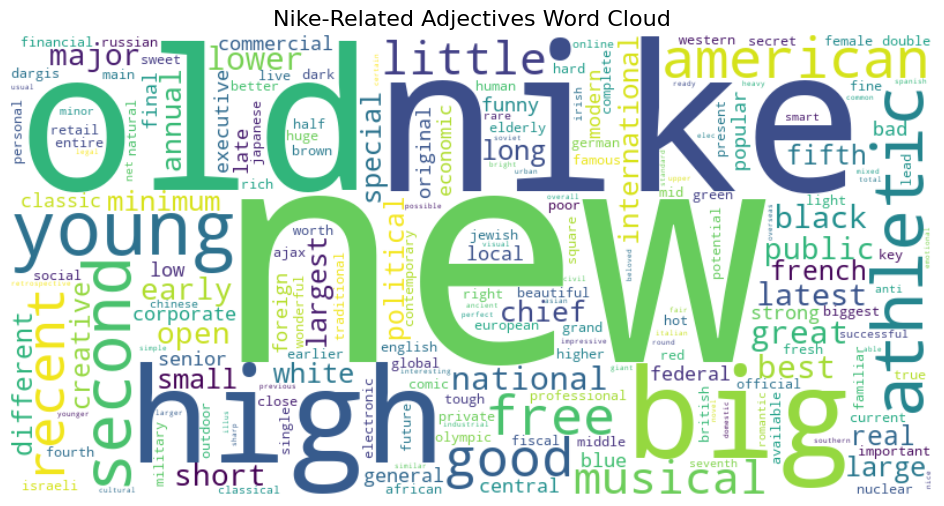

In [50]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Query adjectives from Nike articles
nike_adj_query = {
    "brands_mentioned": {"$in": ["nike"]},
    "adjectives": {"$exists": True, "$ne": []}
}

cursor = collection.find(nike_adj_query, {"adjectives": 1})

# Step 2: Gather all adjectives
all_adjectives = []
for doc in cursor:
    all_adjectives.extend(doc.get("adjectives", []))

# Step 3: Count frequencies
adj_freq = Counter(all_adjectives)

# Step 4: Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"  # optional: 'cool', 'plasma', 'Blues', etc.
).generate_from_frequencies(adj_freq)

# Step 5: Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nike-Related Adjectives Word Cloud", fontsize=16)
plt.show()


#### Visualization of freequently used tokens in 'Nike' news

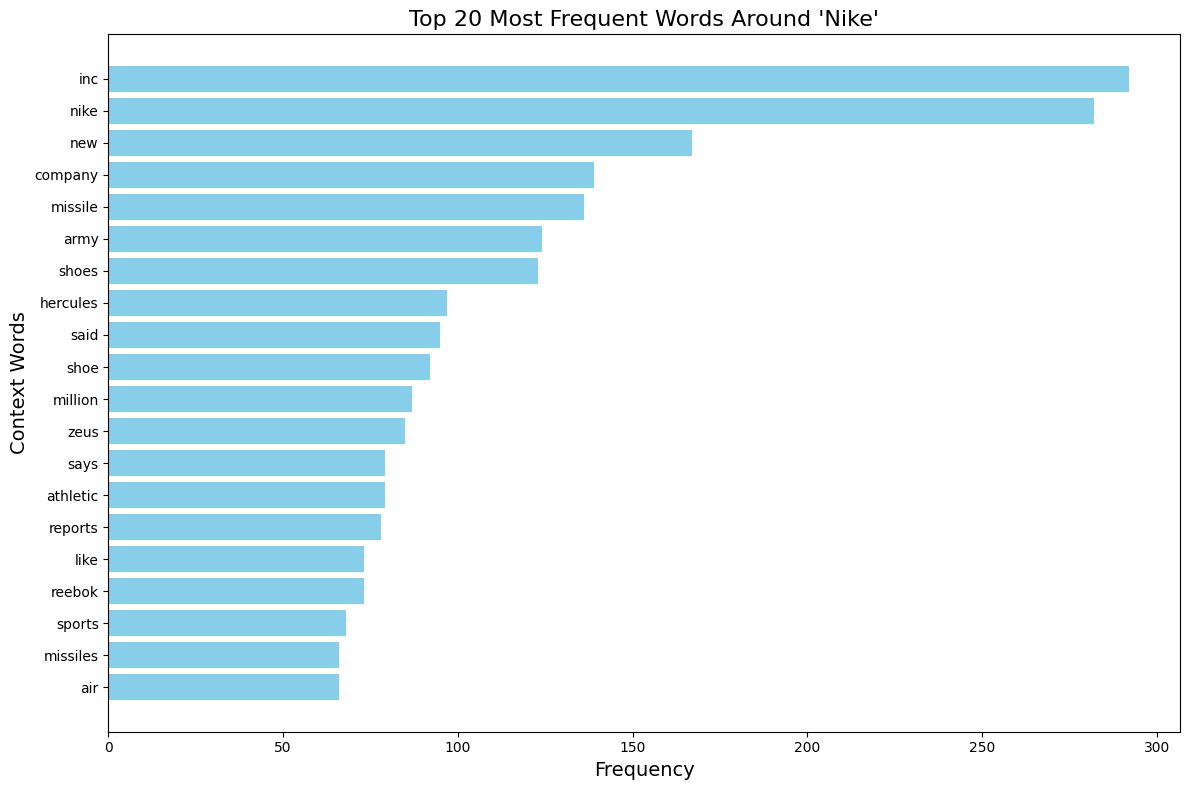

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the top context words
top_20_df = pd.DataFrame(top_context_words, columns=["Word", "Frequency"])

# Sort for better plotting (optional, already sorted by most_common)
top_20_df = top_20_df.sort_values(by="Frequency", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_20_df["Word"], top_20_df["Frequency"], color='skyblue')
plt.title("Top 20 Most Frequent Words Around 'Nike'", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Context Words", fontsize=14)
plt.tight_layout()
plt.show()


#### Sentiment Analysis of Nike Articles

In [54]:
import numpy as np

# Fetch Nike articles with sentiment scores
cursor = collection.find(
    {"brands_mentioned": "nike", "sentiment": {"$exists": True}},
    {"title": 1, "sentiment": 1}
)

# Print the sentiment details for the first 10 Nike articles
print("Nike Articles Sentiment Details:\n")
for doc in cursor.limit(10):  # You can remove `.limit(10)` to show all
    title = doc.get("title", "")[:60]
    sentiment = doc.get("sentiment", 0)
    
    if sentiment > 0:
        category = "Positive"
    elif sentiment < 0:
        category = "Negative"
    else:
        category = "Neutral"
    
    print(f"Title: {title}")
    print(f"Sentiment Score: {sentiment:.3f} ({category})\n")

Nike Articles Sentiment Details:



#### Common Positive and Negative Tokens for Nike:

In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import nltk

# Setup
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Token Counters
positive_tokens = Counter()
negative_tokens = Counter()

# Fetch preprocessed tokens
cursor = collection.find(
    {"brands_mentioned": "nike", "filtered_tokens": {"$exists": True}},
    {"filtered_tokens": 1}
)

# Loop through and score tokens
for doc in cursor:
    tokens = doc.get("filtered_tokens", [])
    for token in tokens:
        score = sid.polarity_scores(token)["compound"]
        if score > 0.1:
            positive_tokens[token] += 1
        elif score < -0.1:
            negative_tokens[token] += 1

# Top 10
top_positive = positive_tokens.most_common(10)
top_negative = negative_tokens.most_common(10)

# Output
print("\nCommon Positive Tokens for Nike:")
for word, count in top_positive:
    print(f"{word}: {count} occurrences")

print("\nCommon Negative Tokens for Nike:")
for word, count in top_negative:
    print(f"{word}: {count} occurrences")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shelbyjoji/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Common Positive Tokens for Nike:
like: 461 occurrences
play: 239 occurrences
united: 211 occurrences
well: 201 occurrences
free: 196 occurrences
best: 181 occurrences
defense: 144 occurrences
good: 136 occurrences
great: 132 occurrences
top: 130 occurrences

Common Negative Tokens for Nike:
lower: 123 occurrences
war: 102 occurrences
hard: 81 occurrences
pay: 75 occurrences
death: 73 occurrences
fired: 73 occurrences
miss: 67 occurrences
cut: 65 occurrences
lost: 64 occurrences
anti: 62 occurrences


#### Time Series of Nike Mentions

In [58]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Run the aggregation pipeline to get the number of mentions by year
pipeline = [
    {"$match": {"brands_mentioned": "nike", "year": {"$exists": True}}},
    {
        "$group": {
            "_id": "$year",
            "count": {"$sum": 1}
        }
    },
    {"$sort": {"_id": 1}}  # Sort by year in ascending order
]

# Get the results from the pipeline
nike_by_year = list(collection.aggregate(pipeline))

In [59]:
# Sort the data by count to get the top 5 years with the most mentions
sorted_nike_by_year = sorted(nike_by_year, key=lambda x: x['count'], reverse=True)

# Print the top 5 years
print("Top 5 Years with Most Nike Mentions:")
for doc in sorted_nike_by_year[:5]:
    print(f"Year {doc['_id']}: {doc['count']} articles")

Top 5 Years with Most Nike Mentions:
Year 2005: 93 articles
Year 2006: 93 articles
Year 1996: 79 articles
Year 1993: 66 articles
Year 1958: 65 articles


#### Visualize 'Nike' mentions in news articles throughout the years

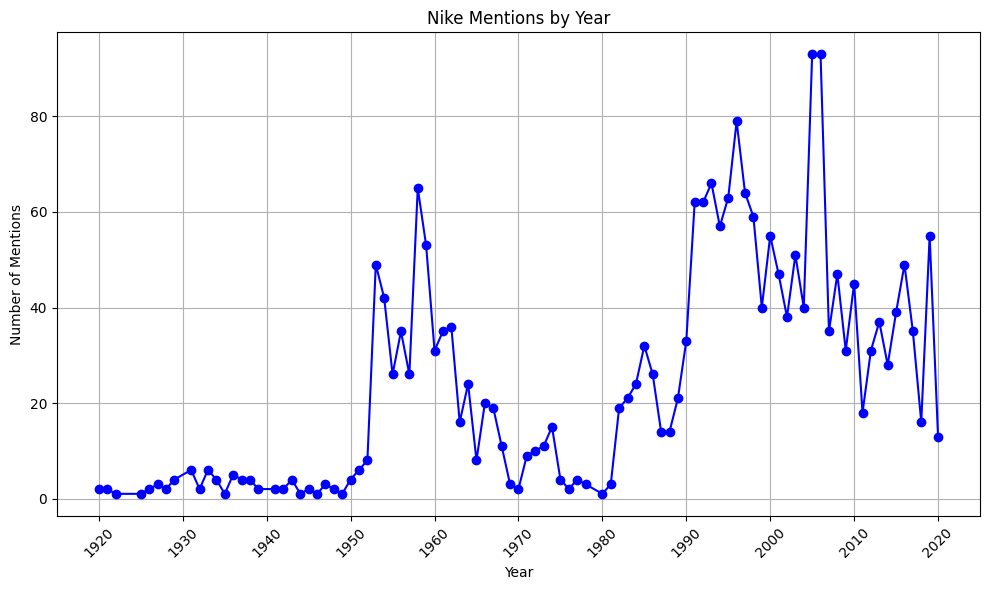

In [61]:
import matplotlib.pyplot as plt

# Extract years and counts for plotting
years = [doc["_id"] for doc in nike_by_year]
counts = [doc["count"] for doc in nike_by_year]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', color='b', label="Nike Mentions")

# Title and labels
plt.title("Nike Mentions by Year")
plt.xlabel("Year")
plt.ylabel("Number of Mentions")

# Adjust x-axis ticks to display labels every 10 years
plt.xticks(range(min(years), max(years)+1, 10), rotation=45)  # Set ticks every 10 years

# Display grid
plt.grid(True)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


#### Comparison of adjectives present in Nike and other brands

In [65]:
from collections import Counter
import pandas as pd

# Nike adjectives
nike_adj_freq = Counter()
nike_docs = collection.find(
    {"brands_mentioned": "nike", "adjectives": {"$exists": True}},
    {"_id": 0, "adjectives": 1}
)

for doc in nike_docs:
    adjectives = [adj.lower() for adj in doc["adjectives"] if adj.lower() != "nike"]
    nike_adj_freq.update(adjectives)

# Get other brands
brands = collection.distinct("brands_mentioned")
other_brands = sorted([
    brand for brand in brands 
    if brand and isinstance(brand, str) and brand.lower() != "nike"
])

# Collect adjective frequencies for each brand
brand_adj_freqs = {"Nike": nike_adj_freq}

for brand in other_brands:
    brand_counter = Counter()
    brand_docs = collection.find(
        {"brands_mentioned": brand.lower(), "adjectives": {"$exists": True}},
        {"_id": 0, "adjectives": 1}
    )
    
    for doc in brand_docs:
        adjectives = [adj.lower() for adj in doc["adjectives"] if adj.lower() != brand.lower()]
        brand_counter.update(adjectives)
    
    brand_adj_freqs[brand] = brand_counter

# Build a list of unique top adjectives
top_nike_adjs = [word for word, _ in nike_adj_freq.most_common(20)]
for brand in other_brands:
    top_nike_adjs += [word for word, _ in brand_adj_freqs[brand].most_common(10)]

unique_adjs = sorted(set(top_nike_adjs))

# Create DataFrame
data = {}
for brand in ["Nike"] + other_brands:
    data[brand] = [brand_adj_freqs[brand].get(adj, 0) for adj in unique_adjs]

df = pd.DataFrame(data, index=unique_adjs).fillna(0).astype(int)
df = df.reset_index().rename(columns={"index": "Adjective"})
df = df.sort_values(by="Nike", ascending=False)

# Show top 50 adjectives
print(df.head(50).to_string(index=False))


    Adjective  Nike  adidas  asics  hoka  lululemon  new balance  puma  reebok  under armour
          new   794      78    836   158          4          221    59     103             8
          old   249      27    456    54          3           22    29      38             0
         high   221      67    320    31          2           28    10      50             3
          big   196      17    186    23          0           10    27      33             3
        young   189      17    234    44          0            3    25      18             3
     athletic   162      24     12     1          2           10    10      85            10
       second   148      14    112    24          0            6    21      32             3
     american   147      19    207    36          0           20    19      37             3
         free   136      21    172    38          0           12    64      13             0
       recent   130       5    168    39          0            4     9

#### Write to a Json file with Mongodb dictionary (Brand name exists)

In [69]:
import json
from pymongo import MongoClient

# Query to find documents with non-empty 'brands_mentioned'
query = {"brands_mentioned": {"$exists": True, "$ne": []}}

# Fetch all matching documents
cursor = collection.find(query)

# Convert cursor to a list of dicts, excluding MongoDB’s ObjectId for JSON serialization
docs = []
for doc in cursor:
    doc["_id"] = str(doc["_id"])  # Convert ObjectId to string
    docs.append(doc)

# Write to a JSON file
with open("brands_mentioned_data.json", "w", encoding="utf-8") as f:
    json.dump(docs, f, indent=4, ensure_ascii=False)

print("Export complete: 'brands_mentioned_data.json'")

Export complete: 'brands_mentioned_data.json'


#### Fetch Documents with Brand Mentions and Store in DataFrame

In [71]:
# Filter for documents where 'brands_mentioned' exists and is not empty
pipeline = [
    {"$match": {"brands_mentioned": {"$exists": True, "$ne": []}}},
]

# Fetch the documents
docs_with_brands = list(collection.aggregate(pipeline))

# Convert the fetched documents to a pandas DataFrame
df_with_brands = pd.DataFrame(docs_with_brands)

# Display the DataFrame
df_with_brands.head()


,_id,year,title,excerpt,full_text,brands_mentioned,tokens,filtered_tokens,adjectives
0,68093fb68f3d2a47eb9f49c2,1968,"MEXICO CITY, Oct. 23 -- Like every small town,...",Shoes in the Machinery,"mexico city, oct. 23 -- like every small town,...",[adidas],"[mexico, city, oct, like, every, small, town, ...","[mexico, city, oct, like, every, small, town, ...","[small, olympic, unofficial, square, main, ame..."
1,68093fb88f3d2a47eba4515a,1972,"G White, US high jumper competing at Olympic T...",Brinks denies charge; past bribery attempts no...,"g white, us high jumper competing at olympic t...",[adidas],"[white, us, high, jumper, competing, at, olymp...","[white, us, high, jumper, competing, olympic, ...","[high, olympic, past, white]"
2,68093fba8f3d2a47eba6f19e,1974,"MIAMI, July 15&#8212",In the hot sun at the gate to Biscayne College...,"miami, july 15&#8212 in the hot sun at the gat...",[adidas],"[miami, july, in, the, hot, sun, at, the, gate...","[miami, july, hot, sun, gate, biscayne, colleg...","[swift, floppy, red, white, national, red, bei..."
3,68093fbb8f3d2a47eba96d42,1976,Fashions worn by athletes at '76 Summer Olympi...,practice of swapping sweatsuits as means of ac...,fashions worn by athletes at '76 summer olympi...,"[adidas, puma]","[fashions, worn, by, athletes, at, summer, oly...","[fashions, worn, athletes, summer, olympics, d...","[puma, montreal]"
4,68093fbe8f3d2a47ebae3656,1982,"Rick Cave of the Shore Athletic Club, a 25-yea...",,"rick cave of the shore athletic club, a 25-yea...",[adidas],"[rick, cave, of, the, shore, athletic, club, y...","[rick, cave, shore, athletic, club, year, old,...","[athletic, old, invitational, strong, equivalent]"


#### Write to a csv file with Mongodb dictionary (Brand name exists)

In [73]:
# Write to CSV
df_with_brands.to_csv("brands_mentioned_data.csv", index=False)

print("CSV export complete: 'brands_mentioned_data.csv'")

CSV export complete: 'brands_mentioned_data.csv'


#### The path where csv and json gets saved

In [75]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/shelbyjoji/Desktop/MS_Columbia_Spring2025/04_MANAGING_DATA/Group proj


#### Close connection

In [77]:
client.close()

## PART 3 - Neo4j Analysis

In [ ]:
os.getcwd()

In [ ]:
os.setwd('/Users/shelbyjoji/Desktop/MS_Columbia_Spring2025/04_MANAGING_DATA/Group proj')

In [ ]:
import pandas as pd
import csv
import ast
import os


# Load the updated CSV file
df = pd.read_csv("brands_mentioned_data_V5.csv")

# Define allowed keywords (in lowercase)
allowed_keywords = {"musical", "street", "young", "athletic", "good", "new"}

# Helper function to safely parse lists
def parse_list(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except:
        return []

# Initialize cleaned rows
rows = []

for i, row in df.iterrows():
    _id = row["_id"]
    year = row["year"]
    title = row["title"]

    # Safely get sentiment if exists
    sentiment = row.get("sentiment", "")
    if sentiment == "" and "brand_sentiment" in df.columns:
        sentiment = row.get("brand_sentiment", "")

    brands = parse_list(row.get("brands_mentioned", "[]"))
    keywords = parse_list(row.get("adjectives", "[]"))

    if not brands or not keywords:
        continue

    # Normalize to lowercase
    brands = [b.strip().lower() for b in brands]
    keywords = [k.strip().lower() for k in keywords if k.strip().lower() in allowed_keywords]
    # keywords = list(set(keywords ))
    
    if not keywords:
        continue

    for brand in brands:
        for keyword in keywords:
            rows.append([_id, year, title, brand, keyword, sentiment])

# Save cleaned file
output_filename = "article_brand_alltokens_filtered_V5.csv"
with open(output_filename, "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["_id", "year", "title", "brand", "keyword", "sentiment"])
    writer.writerows(rows)

print("ready Done. Rows saved:", len(rows))
print("Saved to:", os.path.abspath(output_filename))


In [ ]:
# Install necessary libraries if needed
!pip3 install tomlkit
!pip3 install -U neo4j

# Import libraries
import os
from urllib.parse import quote
from neo4j import GraphDatabase

# Connect to Neo4j
database_name = "neo4j"
username = "neo4j"
password = "apan5400"
uri = "bolt://localhost:7689/" + database_name

driver = GraphDatabase.driver(uri, auth=(username, password))
session = driver.session()

print(" Successfully connected to Neo4j!")

# Set correct file path
raw_path = os.path.abspath("article_brand_alltokens_filtered_V5.csv")

# Encode special characters
encoded_path = quote(raw_path)

# Final datapath
datapath = f"file:///{encoded_path}"
print("📂 Neo4j-compatible path:", datapath)

# 1st Graph — young, new, athletic
query1 = f"""
LOAD CSV WITH HEADERS FROM '{datapath}' AS line
WITH toLower(line.brand) AS brand, toLower(line.keyword) AS keyword
WHERE keyword IN ['young', 'new', 'athletic']
MERGE (b:Brand {{name: brand}})
MERGE (k:Keyword {{name: keyword}})
MERGE (b)-[:MENTIONED_WITH]->(k)
"""
session.run(query1)
print(" Clean Graph 1 created for ['young', 'new', 'athletic'] with MENTIONED_WITH relationships.")

